In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

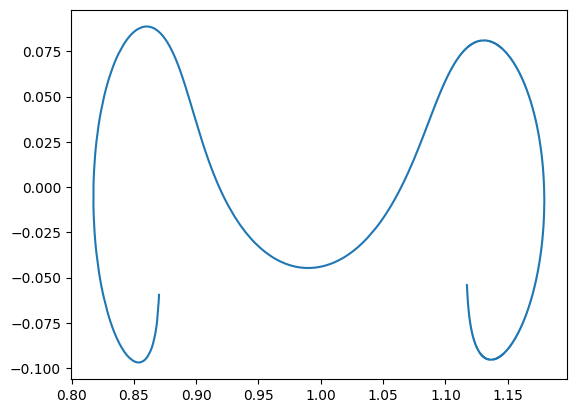

In [76]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [77]:
# three body problem env
import gym
from gym import spaces
import numpy as np

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]


        print(action)
        a_x = action
        a_y = action

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y

        x = x + xdot*self.dt
        y = y + ydot*self.dt
        
        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        reward = 1 - np.linalg.norm(self.position - self.trajectory[self.steps], axis=0)
        done = self.steps >= self.max_steps
        if abs(self.position - self.trajectory[-1]).sum() < 0.005:
            done = True
            reward = 1000
        if self.steps > 1000:
            done = True
            reward = -1000
        if np.linalg.norm(self.state) > 2:
            done = True
            reward = -1000

        return self.state, reward, done, self.position

    def position2state(self):
        # find nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
    
    def reset(self):
        self.position = self.trajectory[0]   
        self.steps = 0
        self.position2state()
        return self.state
    
    def render(self):
        pass

    def close(self):
        pass

    

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time

In [79]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=tf.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [80]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 4000
epochs = 30
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False

In [81]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = three_body_env(trajectory)
observation_dimensions = env.observation_space.shape[0]
num_actions = 2

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.tanh, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, episode_return, episode_length = env.reset(), 0, 0

In [82]:
# Iterate over the number of epochs
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, episode_return, episode_length = env.reset(), 0, 0

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
    )

0
1
0
0
0
1
1
1
1
1
0
0
1
1
0
1
0
1
1
1
1
0
1
0
0
1
1
1
1
0
1
0
0
1
0
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
0
1
0
1
0
0
1
0
0
1
0
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
0
0
1
0
0
1
1
1
0
0
0
0
0
1
1
1
1
0
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
0
1
0
0
0
1
1
0
1
0
0
1
0
1
0
1
1
0
1
0
0
1
1
1
1
0
1
1
0
1
0
1
0
1
1
0
0
0
1
1
0
0
1
1
1
1
1
0
0
0
1
0
0
1
0
1
1
1
0
0
0
0
1
1
1
0
1
0
0
0
0
1
0
0
1
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
1
0
1
0
1
0
0
1
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
0
0
0
0
1
1
1
0
1
0
0
1
1
0
1
1
1
0
1
1
1
1
0
1
0
0
0
1
0
0
0
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
0
0
0
0
1
1
0
1
0
1
1
1
0
0
1
1
0
0
1
0
1
0
0
1
1
0
0
1
0
1
0
0
0
1
1
0
0
1
0
0
1
1
1
0
0
0
0
1
1
0
0
0
1
1
0
1
0
1
0
1
1
1
1
0
1
0
1
1
0
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
1
1
1
0
0
0
0
1
1
0
0
0
0
0
1
1
1
1
1
0
0
1
0
0
0
0
0
1
0
1
0
0
1
1
0
0
0
1
1
0
1
1
1
0
1
1
0
0
0
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
0
0
1
1
0
1
0
1
1
0
1
0
1
0
0
0
0
1
0
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
0
1
0
0
1
1
1
1
0
0
0
1
0
1
0
1
0
1
1
0
0
1
1
1
1
1
0
0
0
1
1
0
0
0
1
1
0


KeyboardInterrupt: 